In [1]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST
#import torchvision.transforms as transforms
from torch.utils.data import Dataset
import spacy
#import pytorch_lightning as pl
#from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import scipy
from sklearn.manifold import TSNE
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import LinearSVC, SVR
from sklearn.multioutput import MultiOutputRegressor
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import scipy.io
import random
import inlp
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig, RobertaModel, RobertaForMaskedLM, RobertaTokenizer, RobertaConfig
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import AlbertTokenizer, AlbertModel, AlbertConfig
from transformers import XLNetTokenizer, XLNetModel, XLNetConfig

from typing import Tuple, Dict
from typing import List
import tqdm
from tqdm import tqdm_notebook
import urllib
import time
import pickle
import inlp, inlp_dataset_handler, inlp_linear_model
import copy
%load_ext autoreload
%autoreload

INFO:transformers.file_utils:PyTorch version 1.4.0 available.


In [2]:
def load_wiki(url = "http://nlp.biu.ac.il/~ravfogs/resources/wiki.1million.raw.txt"):
    
  response = urllib.request.urlopen(url)
  raw = response.read().decode('utf8')
  sents = raw.split("\n")
  
  return sents[:]


def create_docs(sentences: List[str]) -> List[spacy.tokens.Doc]:

    #parsing and toekenizing (NOTE: takes about 10 minutes)
    
    nlp = spacy.load('en_core_web_sm')
    nlp.remove_pipe("ner")
    
    start = time.time()
    
    docs = list(nlp.pipe(sentences, batch_size = 100))
    
    docs = list(docs)
    print(time.time() - start)
    
    return docs


def collect_rec_dataset(docs, n):
    
    contain_rec = []
    for i, doc in tqdm.notebook.tqdm(enumerate(docs), total = len(docs)):
        deps = [tok.dep_ for tok in doc]
        if "relcl" in deps:
            contain_rec.append(doc)
    
    contain_rec_set = set(contain_rec)
    no_rec = [d for d in docs if d not in contain_rec_set]
    data = []
    for i in range(n):
        
        doc_with_rec = random.choice(contain_rec)
        rec_root = random.choice([tok for tok in doc_with_rec if tok.dep_ == "relcl"])
        rec_subtree = list(rec_root.subtree)
        rec_borders = (rec_subtree[0].i, rec_subtree[-1].i)
        rec_subtree_text = [tok.text for tok in rec_subtree]
        is_reduced_relc = "that" not in rec_subtree_text and "which" not in rec_subtree_text and "who" not in rec_subtree_text and "whom" not in rec_subtree_text and "whose" not in rec_subtree_text and "where" not in rec_subtree_text 
        
        # add positive & negative examples
        
        data.append({"doc": doc_with_rec, "relc_borders": rec_borders, "is_reduced": is_reduced_relc, "relc_root_ind": rec_root.i, "label": 1})
        data.append({"doc": random.choice(no_rec), "relc_borders": None, "is_reduced": None, "relc_root_ind": None, "label": 0})
    
    random.shuffle(data)
    return data
    

In [ ]:
wiki_sents = load_wiki()

In [ ]:
wiki_sents = wiki_sents[:200000]
print(wiki_sents[0])
docs = create_docs(wiki_sents)

In [ ]:
with open("sents.pickle", "wb") as f:
    pickle.dump(wiki_sents, f)
    
with open("docs.pickle", "wb") as f:
    pickle.dump(docs, f)

In [3]:
with open("docs.pickle", "rb") as f:
    docs = pickle.load(f)

In [4]:
docs = [d for d in docs if len(d) > 11 and len(d) < 35]
data = collect_rec_dataset(docs, n = 75000)

In [5]:
relc_lengths = [abs(d["relc_borders"][0] - d["relc_borders"][1]) for d in data if d["relc_borders"] is not None]
relc_mean = np.mean(relc_lengths)
relc_std = np.std(relc_lengths)
print(relc_mean, relc_std)

7.8066933333333335 4.568613852430759


In [6]:
reduced = [d for d in data if d["is_reduced"]]
for r in reduced[:10]:
    min_ind, max_ind = r["relc_borders"]
    print(r["doc"][min_ind-3:max_ind+2])

approved a bill to study the Missisquoi and Trout rivers for potential designation as Wild and Scenic Rivers .
continue the deal he had with Joe .
were a place to grow flowers and medicinal herbs but
The two mentions I listed are
nor the expertise to administer all of the details of a particular statute .
are not reasons to delete or complain but
The sporting regulation he has used over the years to keep teams in check relates
the first thread I started )
`` none to compare with the daughters of the Edain ''



## Encoder

In [103]:
class BertEncoder(object):
    
    def __init__(self, device = 'cpu'):

        config = BertConfig.from_pretrained("bert-large-uncased-whole-word-masking", output_hidden_states=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking')
        self.model = BertModel.from_pretrained('bert-large-uncased-whole-word-masking', config = config)

        #config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        #self.model = BertModel.from_pretrained('bert-base-uncased', config = config)
        
        #config = AlbertConfig.from_pretrained("albert-xlarge-v2", output_hidden_states=True)
        #self.tokenizer = AlbertTokenizer.from_pretrained("albert-xlarge-v2")
        #self.model = AlbertModel.from_pretrained("albert-xlarge-v2", config = config)
        #config = RobertaConfig.from_pretrained("roberta-large", output_hidden_states=True)
        #self.tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
        #self.model = RobertaModel.from_pretrained('roberta-large', config = config)
            
        self.model.eval()
        self.model.to(device)
        self.device = device
        
    def tokenize(self, original_sentence: List[str], capitalize = False) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """

        if capitalize:
            
            w = list(original_sentence[0])
            w[0] = w[0].upper()
            
            original_sentence[0] = "".join(w)
            
        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        
        return (bert_tokens, orig_to_tok_map)

    
    def encode(self, sentence: str, layers: List[int]):
        
        
        tokenized_text, orig2tok = self.tokenize(sentence.split(" "))
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            predictions = torch.cat([outputs[2][l] for l in layers], axis = 2).detach().cpu().numpy()
            
            """
            if layer >= 0:
                predictions = outputs[2][layer].detach().cpu().numpy()
            else:
                concat = torch.cat(outputs[2], axis = 0)
                concat = concat[:7, :, :]
                predictions = concat.reshape(concat.shape[1], concat.shape[0] * concat.shape[2])
                
                print(predictions.shape)
                print("----------------------------")
                #predictions = torch.sum(concat, axis = 0).detach().cpu().numpy()
            """
            return (predictions.squeeze(), orig2tok)
        

def collect_bert_states(bert, data: List[Tuple], layers: List[int], by_rec = True, strategy = "mean"):
    
    
    for i,d in tqdm.notebook.tqdm(enumerate(data), total = len(data)):
        
        doc, rec_borders, is_reduced, relc_root_i, label = d["doc"], d["relc_borders"], d["is_reduced"], d["relc_root_ind"], d["label"]
        sent = " ".join([tok.text for tok in doc])
        preds, orig2tok = bert.encode(sent, layers = layers)

        
        if by_rec:
            
                ind = random.choice(range(preds.shape[0]))
                dist = random.choice(range(2, 12))
                
                if label == 1:
                    min_relcl_ind, max_relcl_nax = orig2tok[rec_borders[0]], orig2tok[rec_borders[1]]
                
                if strategy == "mean":
                    if label == 1:
                        
                        states = np.mean(preds[min_relcl_ind:max_relcl_nax+1, :], axis = 0)
                    else:
                        states = np.mean(preds[ind: ind + dist, :], axis = 0)
                elif strategy == "sum":
                    if label == 1:
                         states = np.sum(preds[min_relcl_ind:max_relcl_nax+1, :], axis = 0)   
                    else:
                         states = np.sum(preds[ind: ind + dist, :], axis = 0)                            
                elif strategy == "root":      
                    if label == 1:
                        states = preds[orig2tok[relc_root_i], :]
                    else:

                        states = preds[np.minimum(ind + dist, len(preds) - 1)]
                        
                elif strategy == "rand-word":
                        
                    if label == 1:
                        
                        states = preds[random.choice(range(min_relcl_ind-1, max_relcl_nax+1)), :]
                    else:
                        states = preds[ind]
                else:
                    raise Exception("Strategy {} not supported".format(strategy))                
                
        else:
            cls_state = preds[0]
            avg_state = np.mean(preds, axis = 0)
            sum_state = np.sum(preds, axis = 0)
            max_state = np.max(preds, axis = 0)
            min_state = np.min(preds, axis = 0)
            
            if strategy == "cls":
                states = cls_state
            elif strategy == "mean":
                states = avg_state
            elif strategy == "sum":
                states = sum_state
            elif strategy == "max_min":
                states = np.concatenate([min_state, max_state])
            else:
                raise Exception("Strategy {} not supported".format(strategy))
                
        data[i]["vec"] = states
    
    return data






def collect_bert_states2(bert, data: List[Tuple], layers: List[int], by_rec = True, strategy = "mean"):
    
    
    dists = []
    for i,d in tqdm.notebook.tqdm(enumerate(data), total = len(data)):
        
        doc, rec_borders, is_reduced, relc_root_i, label = d["doc"], d["relc_borders"], d["is_reduced"], d["relc_root_ind"], d["label"]
        sent = " ".join([tok.text for tok in doc]).lower()
        preds, orig2tok = bert.encode(sent, layers = layers)
        
        min_relcl_ind, max_relcl_nax = orig2tok[rec_borders[0]], orig2tok[rec_borders[1]]

        if strategy == "sum":
            states = np.mean(preds[min_relcl_ind:max_relcl_nax+1, :], axis = 0)
        else:
            states = preds[random.choice(range(min_relcl_ind, max_relcl_nax)), :]
            
        chosen = False
        
        
        if random.random() < 0.5:
            
            chosen = False
            counter = 0
            
            while not chosen and counter < 100:
                counter += 1
                ind = random.choice(range(preds.shape[0]))
                dist = random.choice(range(2, 12))
                
                if (ind < min_relcl_ind and (ind + dist < min_relcl_ind)) or ind > max_relcl_nax:
                    
                    dists.append(dist)
                    chosen = True
                    
                    if strategy == "sum":
                        states = np.mean(preds[ind:ind+dist, :], axis = 0)
                    else:
                        states = preds[ind, :]
                    data[i]["label"] = 0
                    break

                
        data[i]["vec"] = states
    print("avg neg distance: ", np.mean(dists))
    #print("avg pos distance: ", )
    
    return data


In [104]:
data_positive = [d for d in data if len(d["doc"]) > 12 and len(d["doc"]) < 35 and d["label"] == 1]
bert = BertEncoder(device = "cpu")
print(len(data_positive), len(data))
data_with_bert_states = collect_bert_states2(bert, copy.deepcopy(data_positive[:50000]), layers = [18], by_rec = True, strategy = "sum")
#data_with_bert_states = collect_bert_states(bert, copy.deepcopy(data[:2000]), layers = [-1], by_rec = True, strategy = "sum")

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-config.json from cache at /home/shauli/.cache/torch/transformers/acdf0fd9c7a1b157516c5c0434216c72438b384fb6ddeeaa20d67e83d1fef81f.fc076a4d5f1edf25ea3a2bd66e9f6f295dcd64c81dfef5b3f5a3eb2a82751ad1
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "

73447 150000



avg neg distance:  5.758757645563588


In [65]:
lengths = [len(d["doc"]) for d in data]
print(np.mean(lengths))
print(np.min(lengths))
print(np.max(lengths))
print(np.std(lengths))

21.92924
12
34
6.235195240653388


## Find best layer

In [87]:


for layer in range(1, 24):
    
    data_with_bert_states = collect_bert_states2(bert, copy.deepcopy(data_positive[:1000]), layers = [layer], by_rec = True, strategy = "sum")    
    
    vecs, labels = np.array([d["vec"] for d in data_with_bert_states]), np.array([d["label"] for d in data_with_bert_states])
    l = int(len(vecs) * 0.8)
    x_train, x_dev = vecs[:l], vecs[l:]
    y_train, y_dev = labels[:l], labels[l:]

    avg = 0
    k = 75
    for i in range(k):
        model = LinearSVC(dual = False, max_iter = 10000) #SGDClassifier(max_iter = 200)
        model = SGDClassifier(max_iter = 10000, alpha = 0.01)
        model.fit(x_train, y_train)
        score = model.score(x_dev, y_dev)
        avg += score
        
    print(layer, avg/k)


avg neg distance:  5.835365853658536
1 0.8938666666666669



avg neg distance:  5.71
2 0.8908666666666668



avg neg distance:  6.019607843137255
3 0.8860666666666672



avg neg distance:  5.705508474576271
4 0.8758



avg neg distance:  5.806818181818182
5 0.9038666666666669



avg neg distance:  5.70276008492569
6 0.9337333333333332



avg neg distance:  5.700836820083682
7 0.9206666666666669



avg neg distance:  5.434077079107505
8 0.9237333333333333



avg neg distance:  5.90138067061144
9 0.9342666666666664



avg neg distance:  5.659574468085107
10 0.9178666666666664



avg neg distance:  6.0
11 0.9116666666666665



avg neg distance:  5.688755020080321
12 0.9180666666666667



avg neg distance:  5.661943319838056
13 0.9358666666666668



avg neg distance:  5.8354430379746836
14 0.9099999999999996



avg neg distance:  5.7664092664092665
15 0.9057333333333333



avg neg distance:  5.717434869739479
16 0.9069999999999999



avg neg distance:  5.828685258964144
17 0.9128666666666665



avg neg distance:  5.729838709677419
18 0.9108666666666668



avg neg distance:  5.787321063394683
19 0.9159333333333333



avg neg distance:  5.733727810650888
20 0.8893333333333335



avg neg distance:  5.887295081967213
21 0.9022666666666666



avg neg distance:  5.938524590163935
22 0.9108666666666665



avg neg distance:  5.797131147540983
23 0.8551333333333334


In [ ]:
with open("data_with_bert-large_states.pickle", "wb") as f:
    
    pickle.dump(data_with_bert_states, f)

## Do BERT CLS states clsuter to groups according to the presence of REC?

In [105]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))

  

  if not color_gradient:
      plt.figure(figsize=(6, 5))
      colors = "red", "blue"
      #colors = [(255,13,12) for n in names]
    
      for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        #print(len(vecs_2d[labels == i, 0]))
        plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                    label=label if ind2label is None else ind2label[label], alpha = 0.3)
      plt.legend()
  

  plt.title(title)

In [106]:
vecs, labels = np.array([d["vec"] for d in data_with_bert_states]), np.array([d["label"] for d in data_with_bert_states])
l = int(len(vecs) * 0.8)
x_train, x_dev = vecs[:l], vecs[l:]
y_train, y_dev = labels[:l], labels[l:]
print(np.sum(y_train) / len(y_train))

0.494875


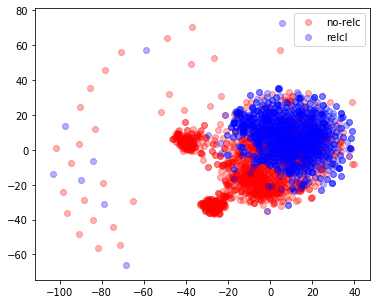

In [107]:
tsne(x_dev[:2500, :], y_dev[:2500], ind2label = {1: "relcl", 0: "no-relc"})

## Predict the presence of REC from the representation

In [158]:
avg = 0.
k = 10
for i in range(k):
    #model = LinearSVC(dual = False, max_iter = 10000) #SGDClassifier(max_iter = 200)
    model = SGDClassifier(max_iter = 10000, alpha = 0.01)
    model.fit(x_train, y_train)
    avg += model.score(x_dev, y_dev)

print(avg/k)
print(model.coef_[0,:10])

0.96132
[-0.01622314 -0.06342715  0.01345789  0.06576001 -0.05442822 -0.03671712
  0.03780464  0.06051453  0.07398621  0.01541912]


In [110]:
preds_dev = model.predict(x_dev)
mistakes = preds_dev != y_dev
mistakes_idx = np.arange(len(x_dev))[mistakes]
mistakes_idx[:100]
dev_data = data_with_bert_states[l:]
print(len(mistakes), len(data_with_bert_states))
mistakes_data = [d for i,d in enumerate(dev_data) if mistakes[i]]

mistakes_data[0]
for i in range(100):
    print(mistakes_data[i]["doc"])
    print("=======================================")

10000 50000
In all the time I was in the CID in the 1970s I never saw a copper in a leather bomber jacket and I never heard an officer call anyone 'guv ' .
There were naval skirmishes , but no scholarly sources to establish that this was notable as a battle , and no sources that even give the skirmish a name .
He suggested that children who are victims of sexual abuse depict a range of symptoms that include secrecy , helplessness , entrapment , accommodation , delayed and conflicted disclosure and recantation .
The quarterly cultural magazine The Dublin Review is launched by Brendan Barrington .
I would still like to ask whether it is appropriate to delete the original of images that are identical , when that loses its history of prior uploads .
One of the first products to use Konarka 's cells was to be briefcases that could recharge laptops .
AIV board where issuing multiple warnings is the correct method of procedure .
In Stockbridge , Massachusetts , where he has the Image Gallery 

## INLP

In [111]:
inlp_dataset = inlp_dataset_handler.ClassificationDatasetHandler(x_train, y_train, x_dev, y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
#inlp_model_handler = inlp_linear_model.SKlearnClassifier(LinearSVC, {"dual": False, "max_iter": 5000})
inlp_model_handler = inlp_linear_model.SKlearnClassifier(SGDClassifier, {"max_iter": 10000, "alpha": 0.01, "n_iter_no_change": 10})

In [159]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 3, input_dim = 1024, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)


iteration: 2, accuracy: 0.8786: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


In [170]:
P_rowspace = np.eye(P.shape[0]) - P

In [161]:
relc_vecs = np.array([x for x,y in zip(x_train, y_train) if y == 1])
relc_data = [d for d in data_with_bert_states[:l] if d["label"] == 1]
relc_vecs.shape
relc_vecs_projected = P_rowspace.dot(relc_vecs.T).T

relc_vecs_projected_low_dim = []
for v in tqdm.notebook.tqdm(relc_vecs, total = len(relc_vecs)):
    
    v_rowspace = []
    for w in Ws:
        
        w_norm = w/np.linalg.norm(w)
        v_rowspace.append(w_norm.dot(v.T).item())
    
    v_rowspace = np.array(v_rowspace)
    relc_vecs_projected_low_dim.append(v_rowspace)
    
relc_vecs_projected_low_dim = np.array(relc_vecs_projected_low_dim)

is_reduced = np.array([True if d["is_reduced"] else False for d in relc_data])

vecs_reduced_relc = relc_vecs[is_reduced]
model.score(vecs_reduced_relc, np.ones(len(vecs_reduced_relc)))
is_reduced_docs = [d["doc"] for i,d in enumerate(relc_data) if is_reduced[i]]
for i in range(5):
    print(is_reduced_docs[i])
    print("======================================")
print("======================================================================")
    
is_obj_relc = np.array([True if d["doc"][d["relc_borders"][-1]].pos_ == "VERB" else False for d in relc_data])
is_obj_relc_docs = [d["doc"] for i,d in enumerate(relc_data) if is_obj_relc[i]]
vecs_obj_relc = relc_vecs[is_obj_relc]

for i in range(10):
    print(is_obj_relc_docs[i])
    print("======================================")


If that helps there are ways to make the priority permanently increase .
It reminds me of the past and everything my parents thought me .
But some residents believe the poor weather during Super Bowl week negatively impacted the city 's chances of hosting another Super Bowl , including the bid it lost for the 2009 Super Bowl .
With the loss of Griff , Zone decides that it 's time for Iris to have a gun to protect herself .
Upon interviewing the remaining crew with conflicting accounts the general consensus was the mutiny occurred on December 29 , 1992 when a dispute between a smuggler and the captain broke out .
If that helps there are ways to make the priority permanently increase .
Kinks ' frontman Ray Davies , remembering his older sister going on dates to the local Palais dance hall where big bands would play .
Hage-danuki , who praised , `` well done , my opponent '' in a loud voice , was told by the soldier , `` insolent fellow !
The centre is unusual in that it is built on stil

In [162]:
relc_vecs_projected_low_dim.shape

(19795, 3)

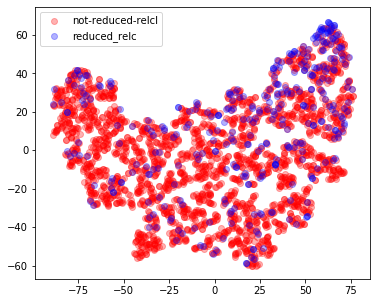

In [175]:
tsne(relc_vecs_projected_low_dim[:3000], is_reduced[:3000], ind2label = {1: "reduced_relc", 0: "not-reduced-relcl"})

In [164]:

def to_string(np_array):
        return "\t".join(["%0.4f" % x for x in np_array])


def save_vecs_and_labels(vecs, is_reduced_labels, is_object_labels, data):
    
    with open("vecs.tsv", "w") as f:
        
        for v in vecs:
            
            f.write(to_string(v) + "\n")
    
    with open("labels.tsv", "w") as f:
        
        f.write("sent" + "\t" + "relc" + "\t" + "is_reduced" + "\t" + "is_obj" + "\t" + "length" + "\n")
        
        for d, is_reduced, is_obj in zip(data, is_reduced_labels, is_object_labels):
        
            sent = [tok.text for tok in d["doc"]]
            borders = d["relc_borders"]
            length = abs(borders[1] - borders[0])
            
            for j,w in enumerate(sent):
            
                if j >= borders[0] and j <= borders[1]:
                
                    sent[j] = w.upper()
            
            relc = sent[borders[0]:borders[1]+1]
            f.write(" ".join(sent) + "\t"  + " ".join(relc).lower() + "\t" + str(is_reduced) + "\t" + str(is_obj) + "\t" + str(length) + "\n")
            
        

In [165]:
save_vecs_and_labels(relc_vecs_projected_low_dim, is_reduced, is_obj_relc, relc_data)

In [166]:
len(x_train)

40000

In [ ]:
cosine_sims_reduced = sklearn.metrics.pairwise.cosine_similarity(vecs_reduced_relc)
cosins_sims_obj = sklearn.metrics.pairwise.cosine_similarity(vecs_obj_relc)
cosine_sims_all = sklearn.metrics.pairwise.cosine_similarity(relc_vecs)


cosine_sims_reduced_after = sklearn.metrics.pairwise.cosine_similarity(P_rowspace.dot(vecs_reduced_relc.T).T)
cosins_sims_obj_after = sklearn.metrics.pairwise.cosine_similarity(P_rowspace.dot(vecs_obj_relc.T).T)
cosine_sims_all_after = sklearn.metrics.pairwise.cosine_similarity(P_rowspace.dot(relc_vecs.T).T)

In [ ]:
print(np.mean(cosine_sims_reduced), np.mean(cosine_sims_reduced_after))
print(np.mean(cosine_sims_all), np.mean(cosins_sims_obj_after))
print(np.mean(cosins_sims_obj), np.mean(cosine_sims_all_after))

In [169]:
relc_vecs.shape

(19795, 1024)